# Exercise 3: Muli-class Classification and Neural Networks

In this exercise, we will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show how the methods we’ve learned can be used for this classification task.


## Our dataset

We are given a data set in ex3data1.mat that contains 5000 training examples of handwritten digits.
Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9” in their natural order.

In [1]:
% Load saved matrices from file
load('data/ex3data1.mat');
% The matrices X and y will now be in our Octave environment

We will begin by visualizing a subset of the training set.

In [2]:
function [h, display_array] = displayData(X, example_width)
%DISPLAYDATA Display 2D data in a nice grid
%   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
%   stored in X in a nice grid. It returns the figure handle h and the 
%   displayed array if requested.

% Set example_width automatically if not passed in
    if ~exist('example_width', 'var') || isempty(example_width) 
        example_width = round(sqrt(size(X, 2)));
    end

    % Gray Image
    colormap(gray);

    % Compute rows, cols
    [m n] = size(X);
    example_height = (n / example_width);

    % Compute number of items to display
    display_rows = floor(sqrt(m));
    display_cols = ceil(m / display_rows);

    % Between images padding
    pad = 1;

    % Setup blank display
    display_array = - ones(pad + display_rows * (example_height + pad), ...
                       pad + display_cols * (example_width + pad));

    % Copy each example into a patch on the display array
    curr_ex = 1;
    for j = 1:display_rows
        for i = 1:display_cols
            if curr_ex > m, 
                break; 
            end
            % Copy the patch
            
            % Get the max value of the patch
            max_val = max(abs(X(curr_ex, :)));
            display_array(pad + (j - 1) * (example_height + pad) + (1:example_height), ...
                          pad + (i - 1) * (example_width + pad) + (1:example_width)) = ...
                            reshape(X(curr_ex, :), example_height, example_width) / max_val;
            curr_ex = curr_ex + 1;
        end
        if curr_ex > m, 
            break; 
        end
    end

    % Display Image
    h = imagesc(display_array, [-1 1]);

    % Do not show axis
    axis image off

    drawnow;

end

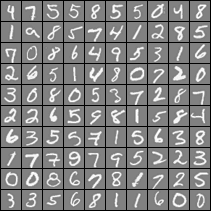

In [3]:
m = size(X, 1);

% Randomly select 100 data points 
rand_indices = randperm(m);
sel = X(rand_indices(1:100), :);
% and display them
displayData(sel);

## Logistic Regression

We will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, we will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that our code is well vectorized.

Since we already did this in exercise 2, we can simply reuse our functions:

In [4]:
function g = sigmoid(z)
%SIGMOID Compute sigmoid function
%   g = SIGMOID(z) computes the sigmoid of z.

    % The function should also work on scalar *and* matrix values 
    g = zeros(size(z));
    
    g = 1 ./ ( 1 + exp(-z));
end

In [5]:
function result = h(theta, x)
    result = (sigmoid(theta' * x'))';
end

In [6]:
function [J, grad] = lrCostFunction(theta, X, y, lambda)
%LRCOSTFUNCTION Compute cost and gradient for logistic regression with 
%regularization
%   J = LRCOSTFUNCTION(theta, X, y, lambda) computes the cost of using
%   theta as the parameter for regularized logistic regression and the
%   gradient of the cost w.r.t. to the parameters. 

    % Initialize some useful values
    m = length(y); % number of training examples
    J = 0;
    grad = zeros(size(theta));
    
    % We can use matrix multiplication to computer our sums
    sum1 = -log(h(theta, X))'*y - log(1-h(theta, X))'*(1-y) ;
    % Special case: don't regularize theta(1), therefore only use theta(2:end)
    reg1 = theta(2:end)'*theta(2:end);
    
    J = 1/m * sum1 + 0.5 * lambda/m * reg1;

    % Again, the sums for the gradient is computed using a matrix mutliplication
    sum2 = X' * (h(theta, X) - y);
    reg2 = lambda/m * theta;
    % Special case: don't regularize theta(1)
    reg2(1) = 0;
    grad = 1/m * sum2 + reg2;

    grad = grad(:);

end

In [7]:
theta_t = [-2; -1; 1; 2];
X_t = [ones(5,1) reshape(1:15,5,3)/10];
y_t = ([1;0;1;0;1] >= 0.5);
lambda_t = 3;
[J grad] = lrCostFunction(theta_t, X_t, y_t, lambda_t);

fprintf('\nCost: %f\n', J);
fprintf('Expected cost: 2.534819\n');
fprintf('Gradients:\n');
fprintf(' %f \n', grad);
fprintf('Expected gradients:\n');
fprintf(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n');


Cost: 2.534819
Expected cost: 2.534819
Gradients:
 0.146561 
 -0.548558 
 0.724722 
 1.398003 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


## Multi-class classification

In [8]:
function [all_theta] = oneVsAll(X, y, num_labels, lambda)
%ONEVSALL trains multiple logistic regression classifiers and returns all
%the classifiers in a matrix all_theta, where the i-th row of all_theta 
%corresponds to the classifier for label i
%   [all_theta] = ONEVSALL(X, y, num_labels, lambda) trains num_labels
%   logistic regression classifiers and returns each of these classifiers
%   in a matrix all_theta, where the i-th row of all_theta corresponds 
%   to the classifier for label i

    % Some useful variables
    m = size(X, 1);
    n = size(X, 2);

    % You need to return the following variables correctly 
    all_theta = zeros(num_labels, n + 1);

    % Add ones to the X data matrix
    X = [ones(m, 1) X];
    
    % Initial thetas for the optimization alorithm
    initial_theta = zeros(n + 1, 1);
    
    % Set options for fmincg
    options = optimset('GradObj', 'on', 'MaxIter', 50);
 
    for c = 1:num_labels
    
        [theta] = ...
            fmincg (@(t)(lrCostFunction(t, X, (y == c), lambda)), ...
                initial_theta, options);
        all_theta(c,:) = theta';
    end
end

In [9]:
lambda = 0.1;
[all_theta] = oneVsAll(X, y, 10, lambda);

Iteration    50 | Cost: 1.388975e-02
Iteration    50 | Cost: 5.725255e-02
Iteration    50 | Cost: 6.416345e-02
Iteration    50 | Cost: 3.905722e-02
Iteration    50 | Cost: 6.183782e-02
Iteration    50 | Cost: 2.172127e-02
Iteration    50 | Cost: 3.602793e-02
Iteration    50 | Cost: 8.587279e-02
Iteration    50 | Cost: 7.914059e-02
Iteration    50 | Cost: 9.988552e-03


In [10]:
function p = predictOneVsAll(all_theta, X)
%PREDICT Predict the label for a trained one-vs-all classifier. The labels 
%are in the range 1..K, where K = size(all_theta, 1). 
%  p = PREDICTONEVSALL(all_theta, X) will return a vector of predictions
%  for each example in the matrix X. Note that X contains the examples in
%  rows. all_theta is a matrix where the i-th row is a trained logistic
%  regression theta vector for the i-th class. You should set p to a vector
%  of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
%  for 4 examples) 

    m = size(X, 1);
    num_labels = size(all_theta, 1);

    % You need to return the following variables correctly 
    p = zeros(size(X, 1), 1);

    % Add ones to the X data matrix
    X = [ones(m, 1) X];
    
    % Compute the results (all_theta needs to be transposed 
    % because each row contains the theta values for one label)
    % Each row in results contains the K values (for each of the K labels) for one element in the dataset. 
    results = h(all_theta', X);
    
    % For each element (i.e. each row), we pick the label with the highest value
    [M, p] = max(results, [], 2);
end


In [11]:
pred = predictOneVsAll(all_theta, X);

fprintf('Training Set Accuracy: %f\n', mean(double(pred == y)) * 100);
fprintf('Expected Accuracy: approx 94.9\n');

Training Set Accuracy: 94.960000
Expected Accuracy: approx 94.9


Let's see what our trained logistic regression function doing on our randomly selected examples from the beginning of this exercise:

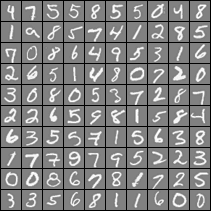

In [12]:
displayData(sel);

In [13]:
% Predict the labels for the selection and convert label 10 to 0
guessed_numbers = mod(predictOneVsAll(all_theta, sel), 10);

In [14]:
% ... and print them as a matrix 
reshape(guessed_numbers, [10,10])'

ans =

   9   7   3   5   8   5   5   0   4   8
   1   9   8   5   7   4   1   2   8   5
   7   0   8   6   4   9   3   3   1   6
   2   6   5   1   4   8   0   7   2   0
   3   0   8   0   5   3   7   2   8   7
   2   2   6   5   9   8   1   5   8   4
   6   3   5   9   7   1   5   6   3   8
   1   7   7   8   7   9   5   2   2   3
   0   0   8   6   7   8   1   7   2   5
   3   3   5   6   8   1   1   6   0   0



Cool!